In [2]:
'''

@ Author 
Manpreet Singh

'''

In [ ]:
'''
Business problem :- To Rank order the transactions in their likelihood of being Fraud  (Anomaly Detection)

Possible ways :
1. Supervised :- Using Non_linear Algorithms like Bagging(Random Forest),Boosting(Ada,GBM,XGBoost etc.)
2. Supervised :- Using Deep Neural Networks or Convolutional Neural Networks
3. UnSupervised :- Using K-Means Clustering

4. Self-Supervised :- Auroencoders

Uses of Autoencoders: 
1. Dimensionality Reduction
2. Anomaly Detection 
3. Denoise the image data 
4. Image/Data compressing 
'''

In [ ]:
######################################## Autoencoders for Anamoly Detection ##########################################

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import keras
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
###### Data can be downloaded from:-  https://www.kaggle.com/mlg-ulb/creditcardfraud

In [3]:
data = pd.read_csv("creditcard.csv")

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [218]:
x= pd.DataFrame();
x['count'] = (data['Class'].value_counts()/len(data['Class']))*100
x['class'] = data['Class'].value_counts().index

In [221]:
x

,count,class
0,99.827251,0
1,0.172749,1


In [220]:
data.isnull().values.any()

False

In [6]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
data.drop(['Time'],inplace=True,axis=1)

In [8]:
x = data.loc[:,data.columns!='Class']

In [9]:
y = data['Class']

In [10]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.3, stratify=y)

In [11]:
x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)


In [12]:
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

In [13]:
y_test.value_counts()

0    85295
1      148
Name: Class, dtype: int64

In [14]:
myscale = StandardScaler().fit(x_train)

In [15]:
x_train_scaled = myscale.transform(x_train)
x_test_scaled = myscale.transform(x_test)

In [16]:
x_train_scaled.shape[1]

29

### Model Architecture

In [71]:
#### Input Layer ####
input_layer = tf.keras.Input(shape=(x_train_scaled.shape[1],),name="input")


#### Hidden Layers ####
x = tf.keras.layers.Dense(units = 30, 
                          activation = tf.keras.activations.elu,
                          kernel_initializer = tf.keras.initializers.GlorotNormal(),
                          bias_initializer = tf.keras.initializers.Zeros(),
                          activity_regularizer = regularizers.l1(10e-5),
                          name = "Hidden_layer_1") (input_layer)
x = tf.keras.layers.Dropout(rate=.15)(x)



#### Output Layer ####
output_layer = tf.keras.layers.Dense(x_train_scaled.shape[1],activation='elu',name='Decoder-Output')(x)

In [72]:
mymodel = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name = 'myauto')

### Loss, optimizer, metric

In [73]:
myoptimizer = tf.keras.optimizers.Adam(learning_rate = .001)

myloss = tf.keras.losses.MeanAbsoluteError()

In [74]:
mymodel.compile(optimizer = myoptimizer,
                loss = myloss)

### Model Summary

In [76]:
mymodel.summary()

Model: "myauto"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 29)]              0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 30)                900       
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
Decoder-Output (Dense)       (None, 29)                899       
Total params: 1,799
Trainable params: 1,799
Non-trainable params: 0
_________________________________________________________________


### Callbacks

In [77]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="cred_card_anomaly_autoencoder.h5",
                                                  verbose=0,
                                                  save_best_only=True,
                                                  monitor = 'val_loss')

In [78]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              patience = 5,
                                              mode = 'auto',
                                              restore_best_weights = True)

In [79]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 factor = .2,
                                                 patience = 3,
                                                 mode = 'min',
                                                 verbose = 0,
                                                 min_lr = .01)

### Model Training

In [80]:
model_history = mymodel.fit(x_train_scaled,
                            x_train_scaled,
                            batch_size = 32,
                            epochs = 10,
                            callbacks = [checkpointer,early_stop,reduce_lr],
                            validation_data=(x_test_scaled, x_test_scaled),
                            shuffle = True,
                            ##validation_freq = 2,
                            verbose = 1)
                                

Train on 199364 samples, validate on 85443 samples
Epoch 1/10
199364/199364 [==============================] - 25s 123us/sample - loss: 0.3026 - val_loss: 0.1939
Epoch 2/10
199364/199364 [==============================] - 19s 96us/sample - loss: 0.2417 - val_loss: 0.1834
Epoch 3/10
199364/199364 [==============================] - 22s 112us/sample - loss: 0.2227 - val_loss: 0.1842
Epoch 4/10
199364/199364 [==============================] - 21s 104us/sample - loss: 0.2160 - val_loss: 0.1838
Epoch 5/10
199364/199364 [==============================] - 22s 110us/sample - loss: 0.2134 - val_loss: 0.1857
Epoch 6/10
199364/199364 [==============================] - 22s 108us/sample - loss: 0.2124 - val_loss: 0.1860
Epoch 7/10
199364/199364 [==============================] - 24s 119us/sample - loss: 0.2120 - val_loss: 0.1847


In [40]:
## To Load the Model
#mymodel = load_model('cred_card_anomaly_autoencoder.h5')

In [179]:
#tf.keras.utils.plot_model(mymodel,dpi=96,show_layer_names=True)

### Get hidden layers and use them for dimensionality reduction

In [212]:
## If you want to use autoencoder for dimensionality reduction, and get latent feature set for an 
## input x_test_scaled, we will take the encoded layers of the model and create a new sequential model. 
## Then feed the input and get the encoded form of it. 
 
latent_model = tf.keras.models.Sequential()
latent_model.add(mymodel.get_layer('Hidden_layer_1'))
x_test_scaled_encoded = latent_model.predict(x_test_scaled)

In [217]:
## Here the dimension has increases from 29 to 30 since we used only hidden layer in our network having 30 neurons
x_test_scaled_encoded.shape

(85443, 30)

### Save the model manually 

In [185]:
tf.keras.models.save_model(mymodel,filepath = 'credit_card_autoencoder_v2.h5')

### Training & Test Loss-Epoch PLot

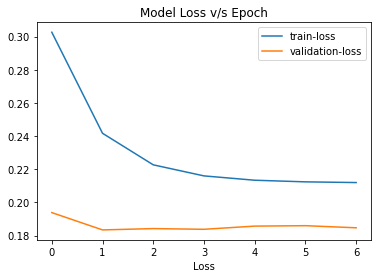

In [81]:
fig,ax = plt.subplots();
ax.plot(model_history.history['loss']);
ax.plot(model_history.history['val_loss']);
plt.xlabel('epoch');
plt.xlabel('Loss');
plt.title('Model Loss v/s Epoch');
plt.legend(['train-loss','validation-loss'],loc='upper right');
plt.show();

In [82]:
predictions = mymodel.predict(x_test_scaled)

In [83]:
np.mean(np.power (predictions,2),axis=1)

array([0.20708716, 0.39741647, 0.19181253, ..., 0.35944876, 0.39164206,
       0.22848292], dtype=float32)

In [84]:
mse = np.mean(np.power(x_test_scaled - predictions, 2), axis=1) ## Mean Square Error

In [85]:
mse

array([0.02997883, 0.16703895, 0.00768267, ..., 0.05375859, 0.15861089,
       0.031571  ])

In [86]:
### In Autoencoder Anomaly detection, the model doesn't predict the class rather we calculate the MSE and 
### fix a threshold, and if mse values which are more than this threshold value are considered as anomaly 

In [123]:
error_df.shape

(85443, 5)

In [161]:
error_df = pd.DataFrame({'Mean_Square_Error': mse,
                        'Actual': y_test})

In [162]:
roc_auc_score(error_df['Actual'],error_df['Mean_Square_Error']) ## .96

0.9674467626662949

In [164]:
error_df[error_df.Actual==0]['Mean_Square_Error'].mean()

0.21600529093991827

In [165]:
error_df[error_df.Actual==1]['Mean_Square_Error'].quantile(.90) ## Top 10% ile == Critical

54.91421718431765

In [166]:
error_df[error_df.Actual==1]['Mean_Square_Error'].quantile(.75) ## Top 25% ile (90-75 = 15%ile == high)

27.830564845050674

In [167]:
error_df[error_df.Actual==1]['Mean_Square_Error'].quantile(.5) ## Top 50% ile (75-50 => 25%ile == Medium)

7.184652571770876

In [169]:
error_df[error_df.Actual==1]['Mean_Square_Error'].quantile(.25) ## Top 75% ile (Bottom 50%ile == Low)

3.13340194551832

In [171]:
error_df['predicted_value']=[1 if e > .8 else 0 for e in list(error_df['Mean_Square_Error'])]
confusion_matrix(error_df['Actual'],error_df['predicted_value'])

array([[83194,  2101],
       [   17,   131]])

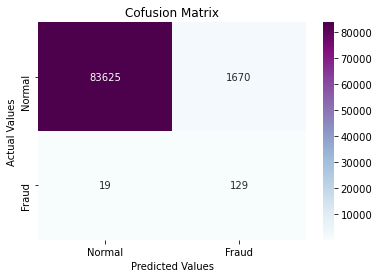

In [126]:
LABELS = ["Normal", "Fraud"]

fig,ax_conf=plt.subplots()
sns.heatmap(confusion_matrix(error_df['Actual'],error_df['predicted_value']),
           xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt="d",
           cmap="BuPu");
ax_conf.set_xlabel('Predicted Values')
ax_conf.set_ylabel('Actual Values')
ax_conf.set_title('Cofusion Matrix')
plt.show();

In [172]:
error_df.sort_values(by='Mean_Square_Error',ascending=False,inplace=True)
error_df.index=range(len(error_df))
error_df['rank']=error_df.index+1
error_df['relative_prob']=1-error_df['rank']/len(error_df)

In [173]:
error_df.head(10)

,Mean_Square_Error,Actual,predicted_value,rank,relative_prob
0,730.001711,0,1,1,0.999988
1,305.845476,0,1,2,0.999977
2,236.594618,0,1,3,0.999965
3,137.939179,0,1,4,0.999953
4,119.394269,0,1,5,0.999941
5,106.329491,0,1,6,0.999930
6,106.220529,0,1,7,0.999918
7,103.233054,0,1,8,0.999906
8,103.184905,1,1,9,0.999895
9,95.317882,1,1,10,0.999883


In [158]:
def lift_model(error_df):
    
    actual=sum(error_df['Actual'])
    count_total = len(error_df)
    percent = actual/count_total
    
    lift_err,percentile_array = [],[]
    
    [percentile_array.append(int(round(np.percentile(error_df.index.values,i)))) for i in range(2,101,2)]
    
    [lift_err.append(round(sum(error_df['Actual'][0:percentile_array[i]])/(percentile_array[i]*percent),2)) for i in range(0,50)]
    
    
    lift=pd.DataFrame({ 
             'Lift_Autoencoder': lift_err,
         'percentile value':percentile_array,
         'percentile' : np.arange(2,101,2)
            })    
    return lift

In [159]:
lift_autoencoder=lift_model(error_df)

In [160]:
lift_autoencoder.head()

,Lift_Autoencoder,percentile value,percentile
0,43.58,1709,2
1,22.63,3418,4
2,15.09,5127,6
3,11.49,6835,8
4,9.26,8544,10


In [ ]:
'''
Interpretation/Observation:

In top 2% of the transactions, rank order in their likelihood to be a fraud, 
our Autoencoder captured ~87% of the frauds. 

In top 10% of the transactions, rank order in their likelihood to be a fraud, 
our Autoencoder captured ~93% of the frauds. 

'''

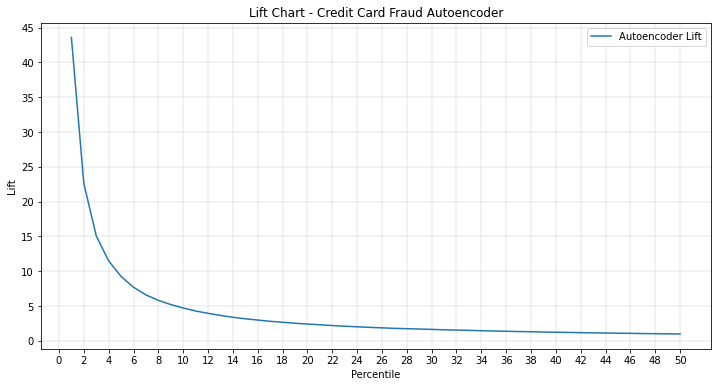

In [133]:
fig,ax_lift=plt.subplots(figsize=(12,6));
ax_lift.plot(lift_autoencoder['percentile'],lift_autoencoder['Lift_Autoencoder'],label='Autoencoder Lift');
ax_lift.set_xlabel('Percentile');
ax_lift.set_ylabel('Lift');
ax_lift.set_title('Lift Chart - Credit Card Fraud Autoencoder');
ax_lift.grid(color='grey',linestyle='-',linewidth=.4,alpha=.5)
plt.xticks(np.arange(0,52,2))
plt.yticks(np.arange(0,50,5))
ax_lift.legend();
plt.show();